# MBML Project

The project explores the application of Variational Autoencoders (VAEs) and their extensions for classification tasks, particularly in scenarios with limited labeled data. The key aspects of the project are:

1. Supervised VAE with classifier addition:
It implements a standard VAE in Pyro and then adds a multiclass linear classifier on top of the latent space to perform supervised classification. This allows comparing classification performance using the learned latent representation.

2. Semi-Supervised VAE (ssVAE):
It extends the VAE to a semi-supervised setting, enabling the model to learn from both labeled and unlabeled data. The ssVAE reconstructs input data and predicts labels, aiming to improve classification accuracy when only a fraction of the data is labeled.

3. Active Learning with Entropy-based Sampling:
It employs an active learning strategy to select the most informative (high entropy) unlabeled data points for labeling. This aims to further enhance the model's performance by focusing on data points that the model is most uncertain about.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from mnist_cached import MNISTCached as MNIST
from mnist_cached import setup_data_loaders
from vae_plots import mnist_test_tsne, plot_llk, plot_vae_samples

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.poutine as poutine
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal

# matplotlib style options
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)


/Users/work/Documents/model-based-machine-learning-ssvae/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Esnure that notebook is reproducible
torch.manual_seed(1234)
np.random.seed(1234)

# 1. Sequential VAE-based classifier

## Purpose

In this first section, the goal is to create a model applicable of predicting accurate labels for the MNIST dataset. 
The expectation is that an efficient Autoencoder will ensure that a compressed latent space, will preserved the "predictable" features of the image, hence it should also make classification on such easier.

Hence, first step of the sequential VAE-based classifier, is to define and train an autoencoder.

This first part, will also be a complete copy of the code presented in course-day 11.

As an addition to the previously presented code, the update has added a function for reconstruction accuracy. 

In [3]:
# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, input_dim):
        self.input_dim = input_dim
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, self.input_dim)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale


# define the PyTorch module that parameterizes the
# observation likelihood p(x|z)
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim, binary=False):
        self.binary = binary
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, output_dim)
        if not self.binary:
            self.fc22 = nn.Linear(hidden_dim, output_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x input_dim
        if self.binary:
            out = torch.sigmoid(self.fc21(hidden))
        else:
            out = (self.fc21(hidden), self.softplus(self.fc22(hidden)))
        return out

In [4]:

# define a PyTorch module for the VAE
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, input_dim=784, binary=False, use_cuda=False):
        self.input_dim = input_dim
        self.binary = binary
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, input_dim)
        self.decoder = Decoder(z_dim, hidden_dim, input_dim, binary=binary)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = torch.zeros(x.shape[0], self.z_dim)
            z_scale = torch.ones(x.shape[0], self.z_dim)
            z = pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))
            img = self.decoder.forward(z)
            if self.binary:
                # sample from the Bernoulli distribution
                pyro.sample("obs", dist.Bernoulli(img, validate_args=False).to_event(1), obs=x.reshape(-1, self.input_dim))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder.forward(x)
            z = pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))


    # define a helper function for reconstructing images (this will useful later - ignore for now)
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img
    
    def recontruct_accuracy(self, x):
        z_loc, z_scale = self.encoder(x)
        z = dist.Normal(z_loc, z_scale).sample()
        recon = self.decoder(z)
        recon_bin = (recon > 0.5).float()
        x_bin = (x > 0.5).float()
        accuracy = (recon_bin == x_bin).float().mean().item()
        return accuracy

### Performance evaluation
This next code is an establishment of general purpose performance evaluation, hence functions that can be reused throughout the project have been defined

In [5]:
def compute_loss(data_loader, model, svi, supervised=False):
    # compute the training loss
    loss = []
    for x, y in data_loader:
        y = np.argmax(y, axis=1)
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        # run the model and guide
        if supervised:
            elbo = svi.evaluate_loss(x,y)
        else:
            elbo = svi.evaluate_loss(x)
        loss.append(elbo)
    return np.mean(loss)

def compute_reconstruct_accuracy(data_loader, model):
    # compute the training accuracy
    dataset_accuracy = []
    for x, _ in data_loader:
        if use_cuda:
            x = x.cuda()
        # run the model and guide
        accuracy = model.recontruct_accuracy(x)
        dataset_accuracy.append(accuracy)
    return np.mean(dataset_accuracy)

def compute_classify_accuracy(data_loader, model):
    # compute the training accuracy
    dataset_accuracy = []
    for x, y in data_loader:
        y = np.argmax(y, axis=1)
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        # run the model and guide
        accuracy = model.accuracy(x, y)
        dataset_accuracy.append(accuracy)
    return np.mean(dataset_accuracy)

def evaluate_model(model, data_loader, svi, supervised=False):
    # Evaluate the model on the given data loader. e.g. train or test set
    # compute the training loss
    loss = compute_loss(data_loader, model, svi, supervised=supervised)
    # compute the training accuracy
    if supervised:
        classify_accuracy = compute_classify_accuracy(data_loader, model)
        reconstruct_accuracy = compute_reconstruct_accuracy(data_loader, model)

        print(f"Loss: {loss:.4f}, Accuracy classifier: {classify_accuracy:.4f}, Accuracy recon: {reconstruct_accuracy:.4f}")
    else:
        classify_accuracy = 0
        reconstruct_accuracy = compute_reconstruct_accuracy(data_loader, model)
        print(f"Loss: {loss:.4f}, Accuracy recon: {reconstruct_accuracy:.4f}")
    return loss, reconstruct_accuracy, classify_accuracy


From the above, the VAE used in this project has been defined. Yet, it is desired to define the classification model, to predict based on the latent space.

1. Define a Pyro model and guide for a multiclass linear classifier 
We will create a K-class linear model y ∼ Categorical(logits = z_loc @ W + b).  

2. Create performance measures

In [6]:
class VAEClassifier:
    def __init__(self, vae, num_classes):
        super().__init__()
        self.vae = vae
        self.num_classes = num_classes

    def model(self, x, obs=None):
        z_loc, _ = self.vae.encoder(x)
        alpha = pyro.sample("alpha", pyro.distributions.Normal(0., 1.).expand( [self.num_classes]).to_event())
        beta = pyro.sample("beta", pyro.distributions.Normal(0., 1.).expand([z_loc.shape[1], self.num_classes]).to_event())
        logits = z_loc @ beta + alpha
        with pyro.plate("data", z_loc.shape[0]):
            y = pyro.sample("y", pyro.distributions.Categorical(logits=logits), obs=obs, infer={"is_auxiliary": True})

    def guide(self, x, obs=None):
        z_loc, _ = self.vae.encoder(x)
        z_dim = z_loc.shape[1]
        # approximate posterior over alpha and beta
        alpha_loc = pyro.param("alpha_loc", torch.zeros(num_classes))
        alpha_scale = pyro.param("alpha_scale", torch.ones(num_classes))
        pyro.sample("alpha", dist.Normal(alpha_loc, alpha_scale).to_event(1))

        beta_loc = pyro.param("beta_loc", torch.zeros(z_dim, num_classes))
        beta_scale = pyro.param("beta_scale", torch.ones(z_dim, num_classes))
        beta = pyro.sample("beta", dist.Normal(beta_loc, beta_scale).to_event(2))

        with pyro.plate("data", z_loc.shape[0]):
            y = pyro.sample("y", pyro.distributions.Categorical(logits=z_loc @ beta_loc + alpha_loc)
                            , infer={"is_auxiliary": True})
    
    def accuracy(self, x, y):
        # encode image x
        z_loc, _ = self.vae.encoder(x)
        alpha_loc = pyro.param("alpha_loc")
        beta_loc = pyro.param("beta_loc")
        logits = z_loc @ beta_loc + alpha_loc

        y_pred = torch.argmax(logits, dim=1)
        accuracy = (y == y_pred).float().mean().item()
        return accuracy


#### 1) Loading the data


In [7]:
# Load the MNIST dataset
loaders = setup_data_loaders(MNIST, use_cuda=False, batch_size=250, sup_num=49000)
data_loader = loaders["sup"]
test_loader = loaders["test"]

# Define the number of classes
num_classes = 10

With the dataloader defined in the Course material, there where issues related to the active learning strategy.
The original implementation would shuffle each time a batch was fetched, making impossible to pick certain images for labelling. 
Hence a static loader is written, to overwrite the shuffled but dynamic dataset that had just been loaded.


In [8]:
from torch.utils.data import Dataset, DataLoader

class CopiedDataset(Dataset):
    def __init__(self, original_loader):
        self.data = []
        for x, y in original_loader:
            self.data.append((x.clone(), y.clone()))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

def copy_dataloader(original_loader):
    # Extract batch size and other relevant parameters from original loader
    batch_size = original_loader.batch_size
    shuffle = False
    
    # Create dataset from copied data
    copied_dataset = CopiedDataset(original_loader)
    
    # Return a new DataLoader with same configuration
    return DataLoader(
        copied_dataset,
        batch_size=1,  # Each item is already a batch
        shuffle=shuffle,
        collate_fn=lambda x: x[0]  # Return the batch directly
    )

# Usage example:
data_loader = copy_dataloader(data_loader)

### 2) Setup training parameters,

In [9]:
# To keep things simple, and performance comparable, we predefine the
# optimi
adam_args = {"lr": 1.0e-3}
optimizer = Adam(adam_args)

# setup the inference algorithm
elbo = Trace_ELBO()

# Code is optimized for GPU, but can run on CPU as well
use_cuda = False

num_epochs = 100


Yet, we are ready to train:

In [10]:
# clear model parameters prior to training
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=use_cuda, z_dim=50, hidden_dim=400, input_dim=784, binary=True)

# setup the optimizer
svi = SVI(vae.model, vae.guide, optimizer, loss=elbo)

train_elbo = {}
test_elbo = {}
# training loop
for epoch in range(num_epochs):
    # initialize loss accumulator
    epoch_loss = 0.0
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in data_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)
    if epoch % 5 == 0:
        # compute the training loss
        print("Epoch %d" % epoch)
        # compute the training loss
        print("Training: ")
        _, _, _ = evaluate_model(vae, data_loader, svi, supervised=False)
        print("Testing: ")
        _, _, _ = evaluate_model(vae, test_loader, svi, supervised=False)

Epoch 0
Training: 
Loss: 41053.3064, Accuracy recon: 0.9119
Testing: 
Loss: 40757.8335, Accuracy recon: 0.9136
Epoch 5
Training: 
Loss: 29907.5741, Accuracy recon: 0.9529
Testing: 
Loss: 29596.4977, Accuracy recon: 0.9541
Epoch 10
Training: 
Loss: 27738.7819, Accuracy recon: 0.9604
Testing: 
Loss: 27518.6969, Accuracy recon: 0.9614
Epoch 15
Training: 
Loss: 26949.3430, Accuracy recon: 0.9630
Testing: 
Loss: 26774.9505, Accuracy recon: 0.9637
Epoch 20
Training: 
Loss: 26603.3972, Accuracy recon: 0.9638
Testing: 
Loss: 26454.5449, Accuracy recon: 0.9643
Epoch 25
Training: 
Loss: 26308.4134, Accuracy recon: 0.9653
Testing: 
Loss: 26183.7280, Accuracy recon: 0.9657
Epoch 30
Training: 
Loss: 26237.9440, Accuracy recon: 0.9655
Testing: 
Loss: 26148.1561, Accuracy recon: 0.9660
Epoch 35
Training: 
Loss: 26013.7292, Accuracy recon: 0.9660
Testing: 
Loss: 25958.0507, Accuracy recon: 0.9664
Epoch 40
Training: 
Loss: 25956.8868, Accuracy recon: 0.9665
Testing: 
Loss: 25893.2707, Accuracy recon: 0

### 3) Train the classifier in Pyro using SVI

You can run standard Pyro SVI over these model/guide definitions.

In [11]:
# Clear out any existing parameter values
# pyro.clear_param_store()
optimizer = Adam({"lr": 1.0e-3})

classifier = VAEClassifier(vae, num_classes)

# Setup SVI
svi_classifier = SVI(
    model=classifier.model,
    guide=classifier.guide,
    optim=optimizer,
    loss=Trace_ELBO(num_particles=3),
)

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for x, y in data_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        y = np.argmax(y, axis=1) 
        # do ELBO gradient and accumulate loss
        epoch_loss += svi_classifier.step(x, y)
    if epoch % 5 == 0:
        # compute the training loss
        print("Epoch %d" % epoch)
        print("Train accuracy: %.2f" % (compute_classify_accuracy(data_loader, classifier)))
        print("Test accuracy: %.2f" % (compute_classify_accuracy(test_loader, classifier)))
        


Epoch 0
Train accuracy: 0.83
Test accuracy: 0.84
Epoch 5
Train accuracy: 0.79
Test accuracy: 0.80
Epoch 10
Train accuracy: 0.77
Test accuracy: 0.78
Epoch 15
Train accuracy: 0.78
Test accuracy: 0.78
Epoch 20
Train accuracy: 0.78
Test accuracy: 0.78
Epoch 25
Train accuracy: 0.78
Test accuracy: 0.78
Epoch 30
Train accuracy: 0.78
Test accuracy: 0.77
Epoch 35
Train accuracy: 0.78
Test accuracy: 0.78
Epoch 40
Train accuracy: 0.79
Test accuracy: 0.79
Epoch 45
Train accuracy: 0.78
Test accuracy: 0.79
Epoch 50
Train accuracy: 0.78
Test accuracy: 0.79
Epoch 55
Train accuracy: 0.77
Test accuracy: 0.78
Epoch 60
Train accuracy: 0.78
Test accuracy: 0.79
Epoch 65
Train accuracy: 0.80
Test accuracy: 0.80
Epoch 70
Train accuracy: 0.79
Test accuracy: 0.80
Epoch 75
Train accuracy: 0.80
Test accuracy: 0.81
Epoch 80
Train accuracy: 0.81
Test accuracy: 0.82
Epoch 85
Train accuracy: 0.81
Test accuracy: 0.82
Epoch 90
Train accuracy: 0.81
Test accuracy: 0.81
Epoch 95
Train accuracy: 0.81
Test accuracy: 0.81


# 2. Semi Supervised VAE
- The model takes partially labelled MINST data from each batch and the model reconstruct and predict the number separately.



### 1) Definition of Semi Supervised VAE

In [12]:
# define a PyTorch module for the VAE
class ssVAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, input_dim=784, binary=False, use_cuda=False):
        self.input_dim = input_dim
        self.binary = binary
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, input_dim)
        self.decoder = Decoder(z_dim, hidden_dim, input_dim, binary=binary)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x, y=None, fraction=1.0):
        BATCH_SIZE = x.shape[0]
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        alpha = pyro.sample("alpha", pyro.distributions.Normal(0., 1.).expand([num_classes]).to_event(1))
        beta = pyro.sample("beta", pyro.distributions.Normal(0., 1.).expand([self.z_dim, num_classes]).to_event(2))
        with pyro.plate("data", x.shape[0]):
            z_loc = torch.zeros(x.shape[0], self.z_dim)
            z_scale = torch.ones(x.shape[0], self.z_dim)
            z = pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))
            # Prepare for classification
            logits =   z @ beta + alpha
            # Reconstruct image
            img = self.decoder.forward(z)

            # Sample from the observation likelihood
            if self.binary:
                # sample from the Bernoulli distribution
                pyro.sample("obs", dist.Bernoulli(img, validate_args=False).to_event(1), obs=x.reshape(-1, self.input_dim))
                is_labelled = (y != -1)
                y[~is_labelled] = 0
                with poutine.mask(mask=is_labelled):
                    with pyro.poutine.scale(scale=1/fraction):
                        pyro.sample("y", dist.Categorical(logits=logits), obs=y, infer={'is_auxiliary': True})

    def guide(self, x, y=None, fraction=None):
        # register PyTorch modules with Pyro
        pyro.module("encoder", self.encoder)

        # approximate posterior over alpha and beta
        alpha_loc = pyro.param("alpha_loc", torch.zeros(num_classes))
        alpha_scale = pyro.param("alpha_scale", torch.ones(num_classes))
        pyro.sample("alpha", dist.Normal(alpha_loc, alpha_scale).to_event(1))

        beta_loc = pyro.param("beta_loc", torch.zeros(self.z_dim, num_classes))
        beta_scale = pyro.param("beta_scale", torch.ones(self.z_dim, num_classes))
        beta = pyro.sample("beta", dist.Normal(beta_loc, beta_scale).to_event(2))
        
        with pyro.plate("data", x.shape[0]):
            # approximate posterior over z
            z_loc, z_scale = self.encoder.forward(x)
            z = pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))

            
            # for unlabeled data, sample y from the classifier
            if y is not None:
                mask_unlabelled = (y == -1)
                if torch.any(mask_unlabelled):
                    logits = z @ beta + alpha_loc
                    with poutine.mask(mask=mask_unlabelled):
                        pyro.sample("y", dist.Categorical(logits=logits),infer={'is_auxiliary': True})
                
    def classifier(self, x):
        z_loc, z_scale = self.encoder(x)
        z = z_loc
        alpha_loc = pyro.param("alpha_loc")
        beta_loc = pyro.param("beta_loc")
        logits = z @ beta_loc + alpha_loc
        return torch.argmax(logits, dim=1)

    # define a helper function for reconstructing images (this will useful later - ignore for now)
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img
    
    def recontruct_accuracy(self, x):
        z_loc, z_scale = self.encoder(x)
        z = dist.Normal(z_loc, z_scale).sample()
        recon = self.decoder(z)
        recon_bin = (recon > 0.5).float()
        x_bin = (x > 0.5).float()
        accuracy = (recon_bin == x_bin).float().mean().item()
        return accuracy

    def accuracy(self, x, y):
        # encode image x
        z, _ = self.encoder(x)
        alpha_loc = pyro.param("alpha_loc")
        beta_loc = pyro.param("beta_loc")
        logits = z @ beta_loc + alpha_loc

        y_pred = torch.argmax(logits, dim=1)
        accuracy = (y == y_pred).float().mean().item()
        return accuracy

### 2) Training Supervised VAE with Classifier

In [13]:

pyro.clear_param_store()

# setup the VAE
ssvae = ssVAE(use_cuda=use_cuda, z_dim=50, hidden_dim=400, input_dim=784, binary=True)

# setup the inference algorithm
elbo = Trace_ELBO()
svi = SVI(ssvae.model, ssvae.guide, optimizer, loss=elbo)

train_elbo = {}
test_elbo = {}

accuracy = []
rec_accuracy = []

# training loop
for epoch in range(num_epochs):
    # initialize loss accumulator
    epoch_loss = 0.0
    epoch_acc = []
    epoch_rec_acc = []
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, y in data_loader:
        # if on GPU put mini-batch into CUDA memory
        y = np.argmax(y, axis=1)
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x, y)
    # Store average accuracy for this epoch

    if epoch % 5 == 0:
        # compute the training loss
        print("Epoch %d" % epoch)
        # compute the training loss
        print("Training: ")
        _, _, _ = evaluate_model(model=ssvae, data_loader=data_loader, svi = svi, supervised=True)
        print("Testing: ")
        _, _, _ = evaluate_model(ssvae, test_loader, svi, supervised=True)


Epoch 0
Training: 
Loss: 44191.2348, Accuracy classifier: 0.5253, Accuracy recon: 0.9085
Testing: 
Loss: 43941.1533, Accuracy classifier: 0.5483, Accuracy recon: 0.9102
Epoch 5
Training: 
Loss: 30923.5602, Accuracy classifier: 0.8582, Accuracy recon: 0.9531
Testing: 
Loss: 30629.7256, Accuracy classifier: 0.8741, Accuracy recon: 0.9543
Epoch 10
Training: 
Loss: 28504.6636, Accuracy classifier: 0.8859, Accuracy recon: 0.9602
Testing: 
Loss: 28251.2405, Accuracy classifier: 0.8964, Accuracy recon: 0.9611
Epoch 15
Training: 
Loss: 27740.3026, Accuracy classifier: 0.8963, Accuracy recon: 0.9625
Testing: 
Loss: 27572.6333, Accuracy classifier: 0.9062, Accuracy recon: 0.9632
Epoch 20
Training: 
Loss: 27281.5042, Accuracy classifier: 0.9011, Accuracy recon: 0.9646
Testing: 
Loss: 27153.5586, Accuracy classifier: 0.9114, Accuracy recon: 0.9651
Epoch 25
Training: 
Loss: 27069.9156, Accuracy classifier: 0.9046, Accuracy recon: 0.9649
Testing: 
Loss: 26953.0525, Accuracy classifier: 0.9159, Accur

### 3) Train Semi-supervised VAE with classifier

In [14]:
def ss_loader(y, ss_fraction):    
    shape = y.shape
    N = len(y)
    # Number of labels to mask
    L1 = int(N * (1-ss_fraction))
    y_masked = y.clone()
    indices = torch.randperm(N)[:L1]
    
    # Set the selected indices to -1
    y_masked[indices] = -1
    
    # Return the tensor and the list of indices that were masked
    return y_masked.reshape(shape), indices.tolist()

In [15]:
# Defining a training and evaluation function for the semi-supervised VAE
def ss_trainer(data_loader, test_loader, svi, ssvae, idxs_unsup, num_epochs=100, verbose=False):
    pyro.clear_param_store()

    train_elbo = {}
    test_elbo = {}
    # training loop
    for epoch in range(num_epochs):
        # initialize loss accumulator
        epoch_loss = 0.0
        # do a training epoch over each mini-batch x returned
        # by the data loader

        for i, (x, y) in enumerate(data_loader):
            y = np.argmax(y, axis=1)
            idx_unsup_new = idxs_unsup[i]
            y[idx_unsup_new] = -1

            if use_cuda:
                x = x.cuda()
                y = y.cuda()
            epoch_loss += svi.step(x, y, fraction=1-len(idx_unsup_new)/len(y))
                
        if epoch % 5 == 0 and verbose:
            print("Epoch %d" % epoch)
            print("Training: ")
            _, _, _ = evaluate_model(ssvae, data_loader, svi, supervised=True)
            print("Testing: ")
            _, _, _ = evaluate_model(ssvae, test_loader, svi, supervised=True)

    return svi, ssvae

In [16]:

pyro.clear_param_store()

# setup the VAE
ssvae = ssVAE(use_cuda=use_cuda, z_dim=50, hidden_dim=400, input_dim=784, binary=True)

svi = SVI(ssvae.model, ssvae.guide, optimizer, loss=elbo)

# Prepare semi-supervised data
fraction = 0.5
idxs_unsup = []
for x, y in data_loader:
    # if on GPU put mini-batch into CUDA memory
    y = np.argmax(y, axis=1)
    y, idx_unsup = ss_loader(y, fraction)
    idxs_unsup.append(idx_unsup)

train_elbo = {}
test_elbo = {}

# training loop
svi, ssvae = ss_trainer(data_loader, test_loader, svi, ssvae, idxs_unsup, num_epochs=100, verbose=True)

Epoch 0
Training: 
Loss: 55565.6849, Accuracy classifier: 0.1033, Accuracy recon: 0.8730
Testing: 
Loss: 55367.3251, Accuracy classifier: 0.1149, Accuracy recon: 0.8734
Epoch 5
Training: 
Loss: 41650.4210, Accuracy classifier: 0.2855, Accuracy recon: 0.9193
Testing: 
Loss: 41341.3509, Accuracy classifier: 0.2967, Accuracy recon: 0.9210
Epoch 10
Training: 
Loss: 37577.5746, Accuracy classifier: 0.4596, Accuracy recon: 0.9301
Testing: 
Loss: 37300.5207, Accuracy classifier: 0.4731, Accuracy recon: 0.9316
Epoch 15
Training: 
Loss: 35928.7645, Accuracy classifier: 0.4925, Accuracy recon: 0.9360
Testing: 
Loss: 35717.3177, Accuracy classifier: 0.5104, Accuracy recon: 0.9375
Epoch 20
Training: 
Loss: 34953.5596, Accuracy classifier: 0.6287, Accuracy recon: 0.9384
Testing: 
Loss: 34659.6884, Accuracy classifier: 0.6441, Accuracy recon: 0.9399
Epoch 25
Training: 
Loss: 34301.1535, Accuracy classifier: 0.5958, Accuracy recon: 0.9419
Testing: 
Loss: 33995.3666, Accuracy classifier: 0.6068, Accur

### 3) Reconstruction of the image compare to original and supervised model

Text(0.5, 1.0, 'Pred/True Label')

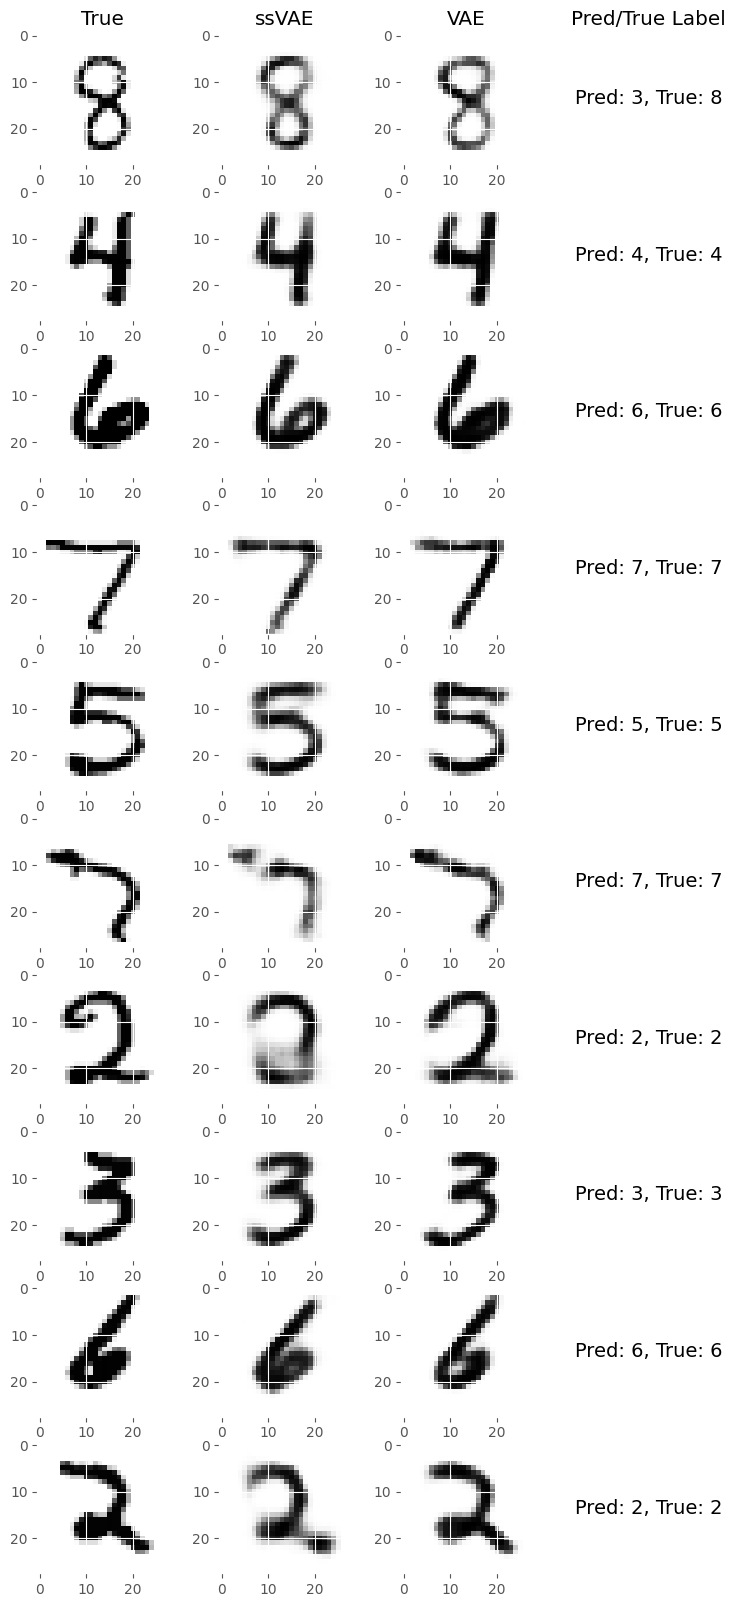

In [17]:
# Obtain both data (x_batch) and labels (y_batch) from the test loader
x_batch, y_batch = next(iter(data_loader))
if use_cuda:
    x_batch = x_batch.cuda()

fig, axs = plt.subplots(10, 4, figsize=(9, 20))

# Pick 10 random images to reconstruct
# reco_indices = np.random.randint(0, x_batch.shape[0], 10)
reco_indices = np.arange(10)
for i in range(10):
    index = reco_indices[i]
    test_img = x_batch[index]

    # Reconstructions from ssVAE and VAE
    reco_img_ssvae = ssvae.reconstruct_img(test_img)
    reco_img_vae = vae.reconstruct_img(test_img)
    
    # Classifier returns a distribution, so extract the predicted label
    pred_label = int(ssvae.classifier(test_img))

    # True label
    true_label = np.argmax(y_batch[index])

    axs[i, 0].imshow(test_img.reshape(28, 28).detach().cpu().numpy(), cmap="Greys")
    axs[i, 1].imshow(reco_img_ssvae.reshape(28, 28).detach().cpu().numpy(), cmap="Greys")
    axs[i, 2].imshow(reco_img_vae.reshape(28, 28).detach().cpu().numpy(), cmap="Greys")

    # Fourth subplot: display predicted and true label
    axs[i, 3].axis("off")
    axs[i, 3].text(
        0.5,
        0.5,
        f"Pred: {pred_label}, True: {true_label}",
        fontsize=14,
        ha="center",
        va="center",
    )

axs[0, 0].set_title("True")
axs[0, 1].set_title("ssVAE")
axs[0, 2].set_title("VAE")
axs[0, 3].set_title("Pred/True Label")


Before moving on to active learning, the performance of the semi-supervised model is assessed.

In [18]:
_, _, _ = evaluate_model(ssvae, test_loader, svi, supervised=True)

Loss: 30452.4114, Accuracy classifier: 0.7524, Accuracy recon: 0.9527


# 3. Active Learning - Entropy based sampling method
The purpose of Active Learning is to ensure that we label only the images that can help us improve learning efficiency.
The most common approach, and what we use in this project, is uncertainty based labelling. Hence we choose those images the causes the highest level of uncertainty.
As the VAE will access the full input dataset, the importance lies in finding the images that causes improvements in classification learning.
A straight forward method is an entropy based uncertainty,
- From each batch, choose the highest entropy samples to include in the training samples.

Many methods of such rely on an unsupervised method, where in this case the latent space would be chosen to maximize uncertainty. However, in our approach we benefit from the supervised case, and pick the datapoints with highest entropy on the logits.
\begin{equation}
    H[y | \mathbf{x}, \mathcal{D}_{\text{train}}] = - \sum_c p(y = c | \mathbf{x}, \mathcal{D}_{\text{train}}) \log p\left(y = c | \mathbf{x}, \mathcal{D}_{\text{train}}\right)
\end{equation}

In [19]:
def compute_entropy(x):
    z = ssvae.encoder(x)[0]
    alpha = pyro.param("alpha_loc")
    beta = pyro.param("beta_loc")
    logits =   z @ beta + alpha
    return dist.Categorical(logits=logits).entropy()

def remove_top_10_entropy(data_loader, idxs_unsup):
    # This function is to create entropy scores for the unsupervised data
    # and then remove the top 10 highest entropy scores
    # from the unsupervised data
    # This is done to label the most uncertain data points
    for i, (x, y) in enumerate(data_loader):
        y = np.argmax(y, axis=1)

        idx_unsup = np.sort(idxs_unsup[i])
        entropy = compute_entropy(x).detach().numpy()
        entropy[~np.isin(np.arange(len(entropy)),idx_unsup)] = -1
        top_10_entropy = entropy.argsort()[-10:]
        idx_unsup_new = [idx for idx in idx_unsup if idx not in top_10_entropy]
        idxs_unsup[i] = idx_unsup_new
    return idxs_unsup

idxs_unsup = remove_top_10_entropy(data_loader, idxs_unsup)


## Now we are ready to performing active learning on the labelling process.
Hence we will start with labelling 10% of the data at random. Afterwards we will labell 10/250 samples in each batch based on entropy. This means that the AL model will request labels where the logits have the highest level of chaos.


In [ ]:
ssAL = ssVAE(use_cuda=use_cuda, z_dim=50, hidden_dim=400, input_dim=784, binary=True)

sviAL = SVI(ssAL.model, ssAL.guide, optimizer, loss=elbo)

# Prepare semi-supervised data
fraction = 0.1
idxs_unsup = []
for x, y in data_loader:
    # if on GPU put mini-batch into CUDA memory
    y = np.argmax(y, axis=1)
    y, idx_unsup = ss_loader(y, fraction)
    idxs_unsup.append(idx_unsup)

train_elbo = {}
test_elbo = {}
idxs_hist = [idxs_unsup.copy()]

# training loop
sviAL, ssAL = ss_trainer(data_loader, test_loader, svi, ssvae, idxs_unsup, num_epochs=100, verbose=False)


for i in range(20): 
    if label_frac <= 0.5:
        break    
    idxs_unsup = remove_top_10_entropy(data_loader, idxs_unsup)
    label_frac = len(idxs_unsup[0])/len(next(iter(data_loader))[0])
    print(f"Label fraction: {label_frac}")
    sviAL, ssAL = ss_trainer(data_loader, test_loader, sviAL, ssAL, idxs_unsup, num_epochs=num_epochs, verbose=False)
    _, _, _ = evaluate_model(ssAL, test_loader, sviAL, supervised=True)
    idxs_hist.append(idxs_unsup.copy())




Label fraction: 0.9
Loss: 28602.8317, Accuracy classifier: 0.8196, Accuracy recon: 0.9581
Label fraction: 0.86
Loss: 28897.2843, Accuracy classifier: 0.7998, Accuracy recon: 0.9578
Label fraction: 0.82
Loss: 28627.4441, Accuracy classifier: 0.7922, Accuracy recon: 0.9585
Label fraction: 0.78
Loss: 28733.7129, Accuracy classifier: 0.7543, Accuracy recon: 0.9587
Label fraction: 0.74
Loss: 28599.0659, Accuracy classifier: 0.8011, Accuracy recon: 0.9584
Label fraction: 0.7
Loss: 28645.4257, Accuracy classifier: 0.7977, Accuracy recon: 0.9582
Label fraction: 0.66
Loss: 28674.9082, Accuracy classifier: 0.8235, Accuracy recon: 0.9584
Label fraction: 0.62
Loss: 28579.2409, Accuracy classifier: 0.8247, Accuracy recon: 0.9586
Label fraction: 0.58
Loss: 28583.2157, Accuracy classifier: 0.8256, Accuracy recon: 0.9587
Label fraction: 0.54
Loss: 28535.4378, Accuracy classifier: 0.8545, Accuracy recon: 0.9589


In [25]:
_, _, _ = evaluate_model(ssAL, test_loader, sviAL, supervised=True)


Loss: 28496.7442, Accuracy classifier: 0.8545, Accuracy recon: 0.9588


In [26]:
from torch.nn.functional import one_hot
def BALD(x):
    # Compute the BALD score for the top 10 samples
    z_loc, z_scale = ssvae.encoder(x)
    alpha = pyro.param("alpha_loc")
    beta = pyro.param("beta_loc")
    scores = np.zeros((x.shape[0], 10))
    for i in range(1000):
        z = dist.Normal(z_loc, z_scale).sample()
        
        logits =   z @ beta + alpha
        # Make one-hot encoding of the logits
        onehot = one_hot(logits.argmax(dim=1), num_classes=num_classes).detach().cpu().numpy()
        scores += np.array(onehot)
    balds  = scores.max(axis=1)
    return balds

def remove_top_10_BALD(data_loader, idxs_unsup):
    # This function is to create BALD scores for the unsupervised data
    # and then remove the top 10 lowest BALD scores
    # from the unsupervised data
    # This is done to label the most uncertain data points
    for i, (x, y) in enumerate(data_loader):
        y = np.argmax(y, axis=1)

        idx_unsup = np.sort(idxs_unsup[i])
        balds = BALD(x)
        balds[~np.isin(np.arange(len(balds)),idx_unsup)] = 1000
        top_10_balds = balds.argsort()[:10]
        idx_unsup_new = [idx for idx in idx_unsup if idx not in top_10_balds]
        idxs_unsup[i] = idx_unsup_new
    return idxs_unsup

In [28]:
ssAL = ssVAE(use_cuda=use_cuda, z_dim=50, hidden_dim=400, input_dim=784, binary=True)

sviAL = SVI(ssAL.model, ssAL.guide, optimizer, loss=elbo)

# Prepare semi-supervised data
fraction = 0.1
idxs_unsup = []
for x, y in data_loader:
    # if on GPU put mini-batch into CUDA memory
    y = np.argmax(y, axis=1)
    y, idx_unsup = ss_loader(y, fraction)
    idxs_unsup.append(idx_unsup)

train_elbo = {}
test_elbo = {}
idxs_hist_BALD = [idxs_unsup.copy()]

# training loop
sviAL, ssAL = ss_trainer(data_loader, test_loader, svi, ssvae, idxs_unsup, num_epochs=100, verbose=False)

for i in range(20): 
    if label_frac <= 0.5:
        break    
    idxs_unsup = remove_top_10_BALD(data_loader, idxs_unsup)
    label_frac = len(idxs_unsup[0])/len(next(iter(data_loader))[0])
    sviAL, ssAL = ss_trainer(data_loader, test_loader, sviAL, ssAL, idxs_unsup, num_epochs=num_epochs, verbose=False)
    print(f"Label fraction: {label_frac}")
    _, _, _ = evaluate_model(ssAL, test_loader, sviAL, supervised=True)
    idxs_hist_BALD.append(idxs_unsup.copy())


Label fraction: 0.9
Loss: 28546.2602, Accuracy classifier: 0.8190, Accuracy recon: 0.9585
Label fraction: 0.86
Loss: 28448.1847, Accuracy classifier: 0.8508, Accuracy recon: 0.9588
Label fraction: 0.82
Loss: 28626.0854, Accuracy classifier: 0.8398, Accuracy recon: 0.9585
Label fraction: 0.78
Loss: 28589.7847, Accuracy classifier: 0.8492, Accuracy recon: 0.9583
Label fraction: 0.74
Loss: 28599.5017, Accuracy classifier: 0.8456, Accuracy recon: 0.9586
Label fraction: 0.7
Loss: 28565.9793, Accuracy classifier: 0.8624, Accuracy recon: 0.9590
Label fraction: 0.66
Loss: 31099.2958, Accuracy classifier: 0.8633, Accuracy recon: 0.9587
Label fraction: 0.62
Loss: 28601.2113, Accuracy classifier: 0.8470, Accuracy recon: 0.9585
Label fraction: 0.58
Loss: 29252.4233, Accuracy classifier: 0.8539, Accuracy recon: 0.9586
Label fraction: 0.54
Loss: 28651.2784, Accuracy classifier: 0.8698, Accuracy recon: 0.9586
Label fraction: 0.5
Loss: 28645.4190, Accuracy classifier: 0.8454, Accuracy recon: 0.9586


Yet, 2 algorithms for active learning have been trained. It could then be of interest to get a visual understand of what points they decide to label, this would also be helpful for future debugging. 

In [31]:
# Perform t-SNE on the latent space

z_all = []
for x, _ in data_loader:
    if use_cuda:
        x = x.cuda()
    z = ssvae.encoder(x)
    z_all.append(z[0].detach().cpu().numpy())
z_all = np.concatenate(z_all, axis=0)
# Plot the t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
z_all_tsne = tsne.fit_transform(z_all)


/Users/work/Documents/model-based-machine-learning-ssvae/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/work/Documents/model-based-machine-learning-ssvae/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/work/Documents/model-based-machine-learning-ssvae/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/work/Documents/model-based-machine-learning-ssvae/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/work/Documents/model-based-machine-learning-ssvae/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Use

In [47]:
# 1. Do as T-sne of the latent space, grey
# 2. use idxs_hist[0] to colour the first iteration labels green
# 3. use idxs_hist[i] to colour the next iteration labels.
def sample_hist(idxs_hist):
    cols = np.zeros((len(idxs_hist[0]), 250))
    for i in range(len(idxs_hist)):
        for j in range(len(idxs_hist[i])):
            pots = np.arange(250)
            pots = np.delete(pots, idxs_hist[i][j])
            for idx in pots:
                if cols[j, idx] == 0:
                    cols[j, idx] = i+1
    cols = np.concatenate(cols, axis = 0)
    return cols


def plot_sample_hist(z_all_tsne, idxs_hist, title = 'Entropy'):
    cols = sample_hist(idxs_hist)
    colors = [
    '#7f7f7f',  # gray
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#bcbd22',  # yellow-green
    '#17becf',   # cyan
    '#000000',   # Black
    '#FFFF00',   # Yellow
    '#800080',   # Purple
    '#469990',   # Teal
    '#e6194b'    # Red
    ]
    cols = sample_hist(idxs_hist)
    z_all_tsne = np.array(z_all_tsne[:len(cols), :])
    cols = np.array(cols[:len(z_all_tsne)])


    plt.figure(figsize=(10, 10))
    for cl in range(len(np.unique(cols))):
        if cl == 0:
            plt.scatter(z_all_tsne[cols == cl, 0], z_all_tsne[cols == cl, 1], s=5, c=colors[cl], alpha=0.5, label=f'Unlabelled')
        else:
            plt.scatter(z_all_tsne[cols == cl, 0], z_all_tsne[cols == cl, 1], s=5, c=colors[cl], label=f'Sample {cl}')

    plt.title("t-SNE of the latent space")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend()
    plt.tight_layout()
    plt.title(f"{title} - t-SNE of the latent space")
    plt.show()

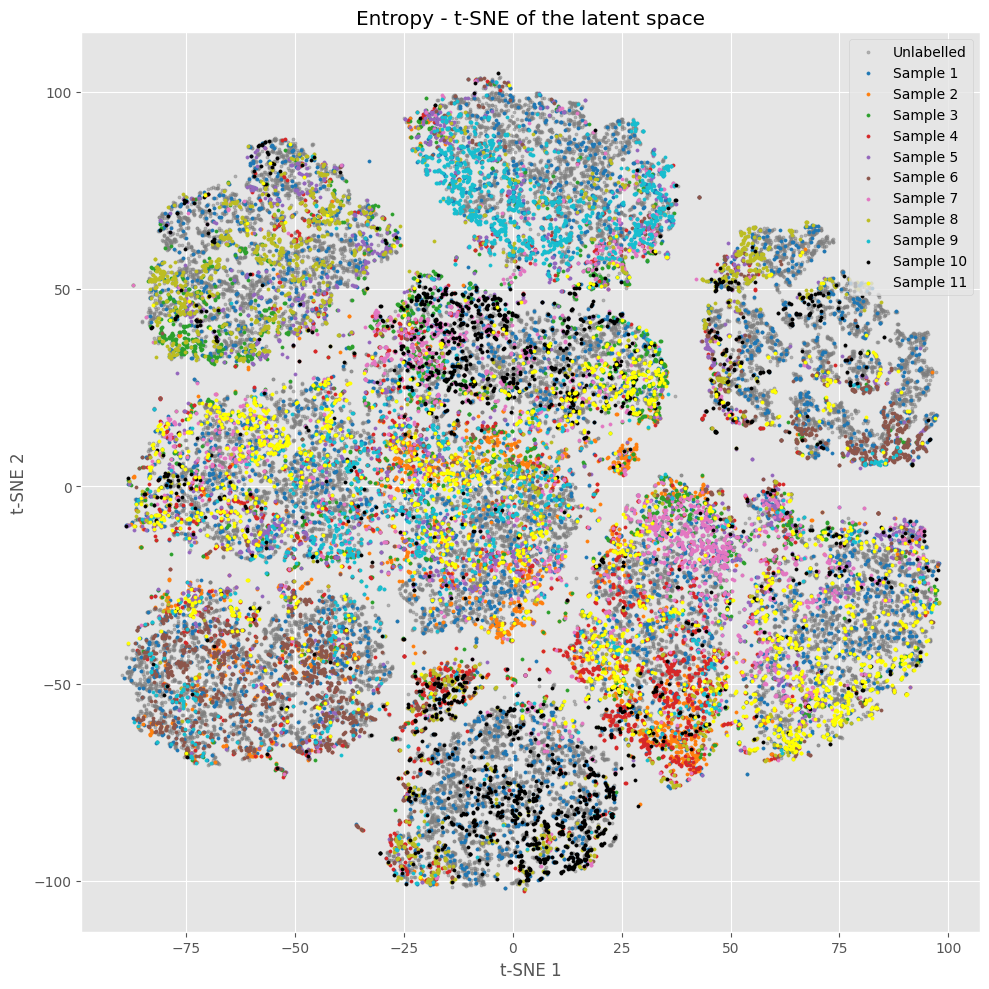

In [48]:
plot_sample_hist(z_all_tsne, idxs_hist, title= "Entropy")

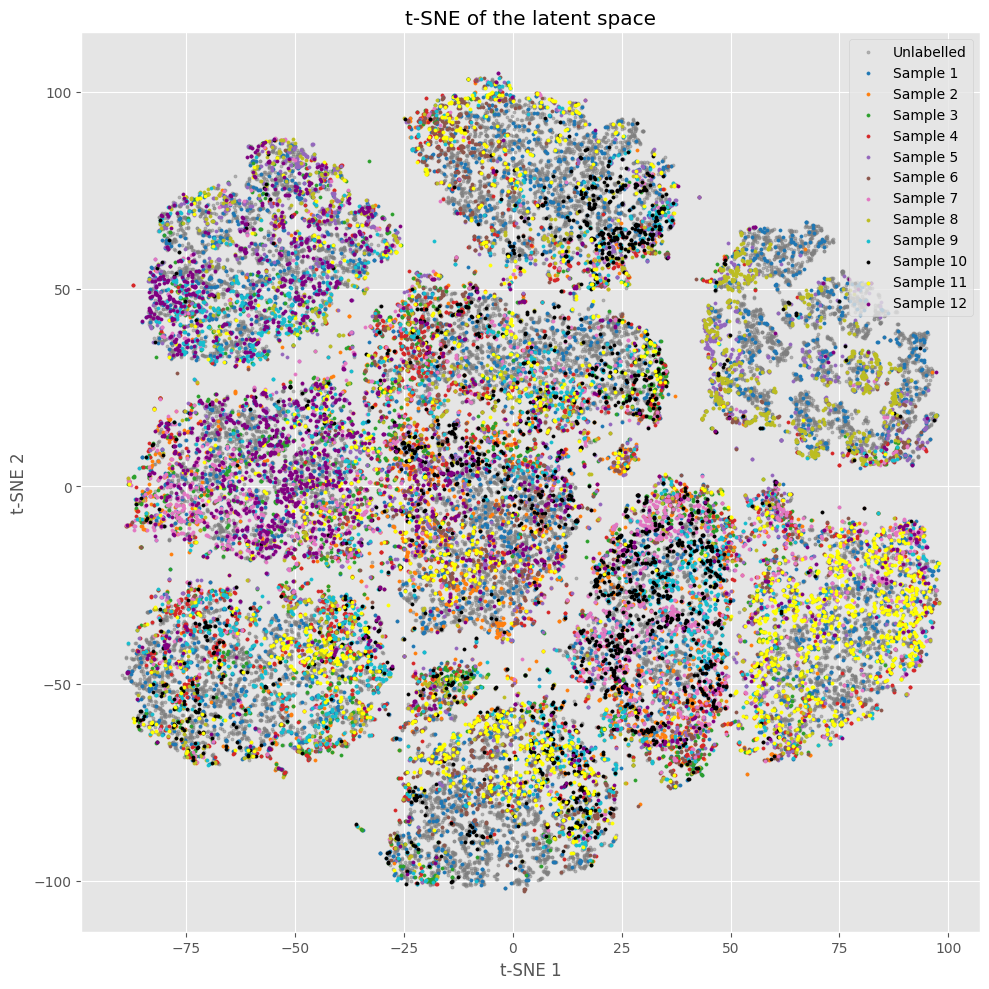

In [ ]:

plot_sample_hist(z_all_tsne, idxs_hist_BALD, title = "BALD")

In [60]:
from scipy.stats import gaussian_kde
import seaborn as sns

def create_density_heatmap(z_all_tsne, idxs_hist, title="Entropy", figsize=(10, 8), cmap='viridis'):
    cols = sample_hist(idxs_hist)
    z_all_tsne = np.array(z_all_tsne[:len(cols), :])
    cols = np.array(cols[:len(z_all_tsne)])
    """
    Create a density heatmap visualization of labeled points in t-SNE space.
    
    Parameters:
    - z_all_tsne: t-SNE coordinates of data points
    - cols: Array indicating if points are labeled (>0) or unlabeled (0)
    - figsize: Figure size
    - cmap: Colormap for density visualization
    
    Returns:
    - Figure object
    """
    plt.figure(figsize=figsize)
    
    # Filter to include only labeled points
    labeled_points = z_all_tsne[cols > 1]
    
    # Create a meshgrid for density calculation
    x_min, x_max = z_all_tsne[:, 0].min() - 1, z_all_tsne[:, 0].max() + 1
    y_min, y_max = z_all_tsne[:, 1].min() - 1, z_all_tsne[:, 1].max() + 1
    xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    
    # Plot unlabeled points as background
    plt.scatter(z_all_tsne[cols == 0, 0], z_all_tsne[cols == 0, 1], 
                s=2, c='lightgray', alpha=0.2, label='Unlabeled')
    
    # Calculate and plot the kernel density estimate
    if len(labeled_points) > 0:
        kde = gaussian_kde(labeled_points.T)
        f = np.reshape(kde(positions), xx.shape)
        plt.imshow(f.T, extent=[x_min, x_max, y_min, y_max], 
                  origin='lower', cmap=cmap, alpha=0.7)
        
    plt.title(f"{title} - Density of AL Labeled Points in t-SNE Space")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.colorbar(label="Density")
    plt.tight_layout()
    
    return plt.gcf()

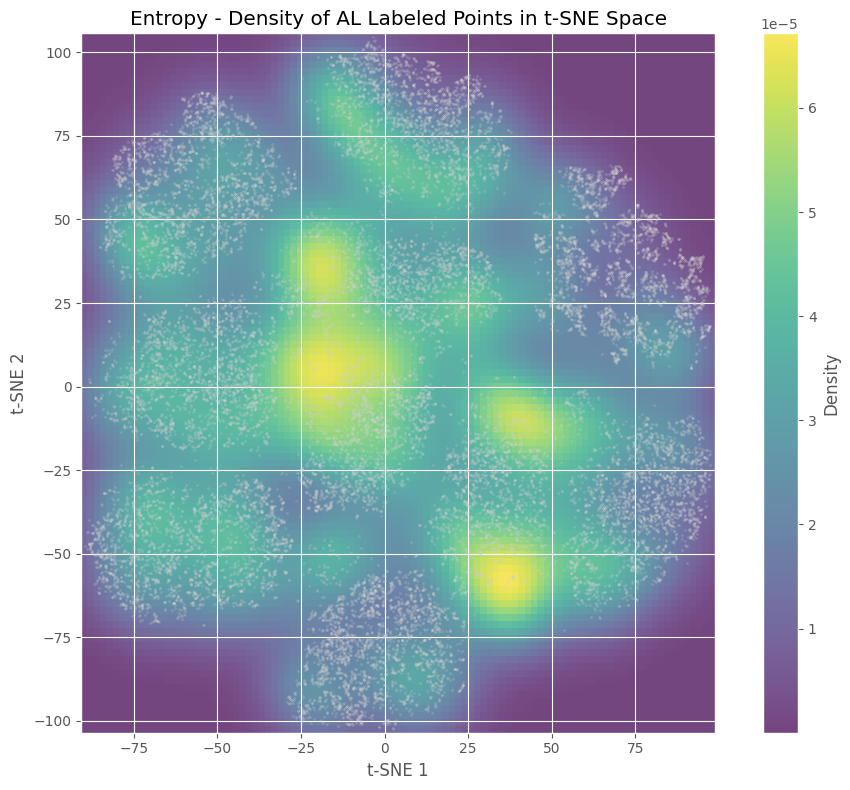

In [61]:
fig = create_density_heatmap(z_all_tsne, idxs_hist, title="Entropy")
plt.show()

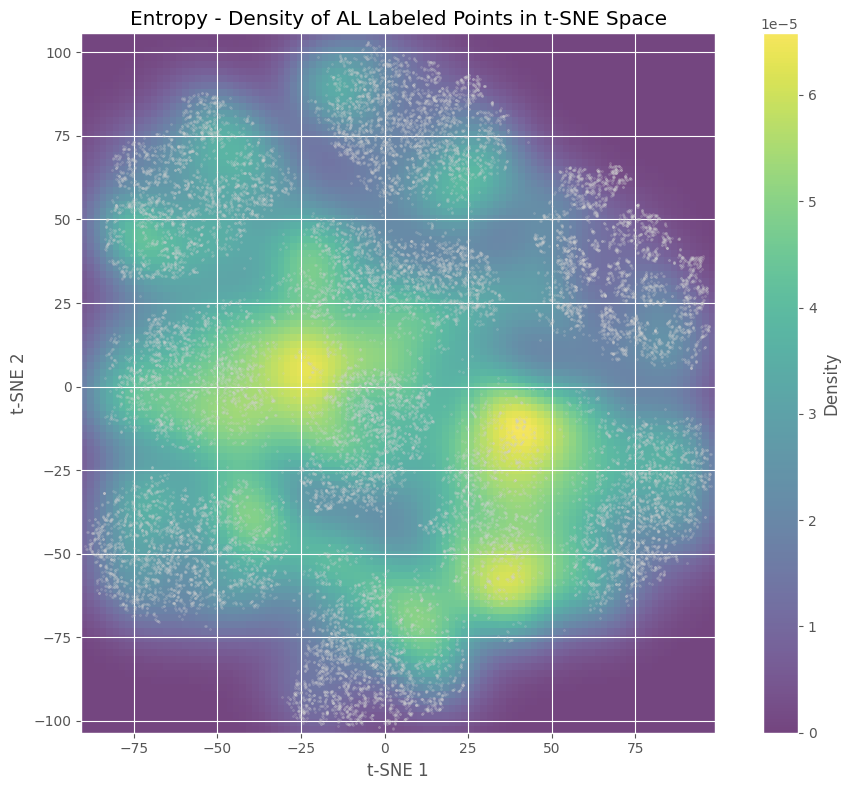

In [62]:
fig = create_density_heatmap(z_all_tsne, idxs_hist_BALD, title="Entropy")
plt.show()

In [58]:
cols = sample_hist(idxs_hist)
sum(cols == 1)/len(cols)

np.float64(0.10449230769230769)

Things for the report.
1. Purpose, what do we want to do and why? - Marcus
    a. Compare Classification on full dataset vs latent space classification. Otherwise, argue why we think latent space is a wiser choice. Less parameters
    b. PGM (Wednesday)
2. Latent space sequential vs fully implemented. - Maria
3. Showcase that we can do semi-supervised VAE. T-SNE comparison, compare classifier performance. (10% fully supervised, vs 10% semi-supervised) - Te
4. Show how amount of labelled data could be utilized with AL approach, logits vs BALD. - Rui
5. Conclude
